In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pandas_profiling
import seaborn as sns
import mpld3
mpld3.enable_notebook()

/home/sohom/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train1 = pd.read_csv("train1.csv")
train9 = pd.read_csv("train9.csv")
hero_data = pd.read_csv("hero_data.csv")
test1 = pd.read_csv("test1.csv")
test9 = pd.read_csv("test9.csv")

In [5]:
train_set =  pd.concat([train1,train9])
validation_set = test9
test_set = test1
train_set = pd.merge(train_set, hero_data, on = 'hero_id')
validation_set = pd.merge(validation_set, hero_data, on = 'hero_id')
test_set = pd.merge(test_set, hero_data, on = 'hero_id')

In [6]:
pandas_profiling.ProfileReport(train_set)

In [7]:
pandas_profiling.ProfileReport(validation_set)

In [8]:
pandas_profiling.ProfileReport(test_set)

In [6]:
train_one_hot = pd.get_dummies(train_set[['primary_attr','attack_type']])
validation_one_hot = pd.get_dummies(validation_set[['primary_attr','attack_type']])
test_one_hot = pd.get_dummies(test_set[['primary_attr','attack_type']])

In [7]:
for st in ['Escape', 'Carry', 'Disabler', 'Initiator', 'Durable', 'Nuker', 'Pusher', 'Jungler', 'Support']:
	train_set[st] = train_set['roles'].apply(lambda x : 1 if st in str(x) else 0)
	validation_set[st] = validation_set['roles'].apply(lambda x : 1 if st in str(x) else 0)
	test_set[st] = test_set['roles'].apply(lambda x : 1 if st in str(x) else 0)


In [8]:
for cl in ['base_health', 'base_mana', 'base_mana_regen']:
	del train_set[cl]
	del validation_set[cl]
	del test_set[cl]


train_all = pd.concat([train_set,train_one_hot], axis = 1)
validation_all = pd.concat([validation_set, validation_one_hot], axis = 1)
test_all = pd.concat([test_set, test_one_hot], axis = 1)


In [9]:
features = ['num_games', 'base_health_regen', 'base_armor', 'base_magic_resistance', 'base_attack_min',
       'base_attack_max', 'base_strength', 'base_agility', 'base_intelligence',
       'strength_gain', 'agility_gain', 'intelligence_gain', 'attack_range',
       'projectile_speed', 'attack_rate', 'move_speed', 'turn_rate', 'Escape',
       'Carry', 'Disabler', 'Initiator', 'Durable', 'Nuker', 'Pusher',
       'Jungler', 'Support', 'primary_attr_agi', 'primary_attr_int',
       'primary_attr_str', 'attack_type_Melee', 'attack_type_Ranged']


target = ['kda_ratio']


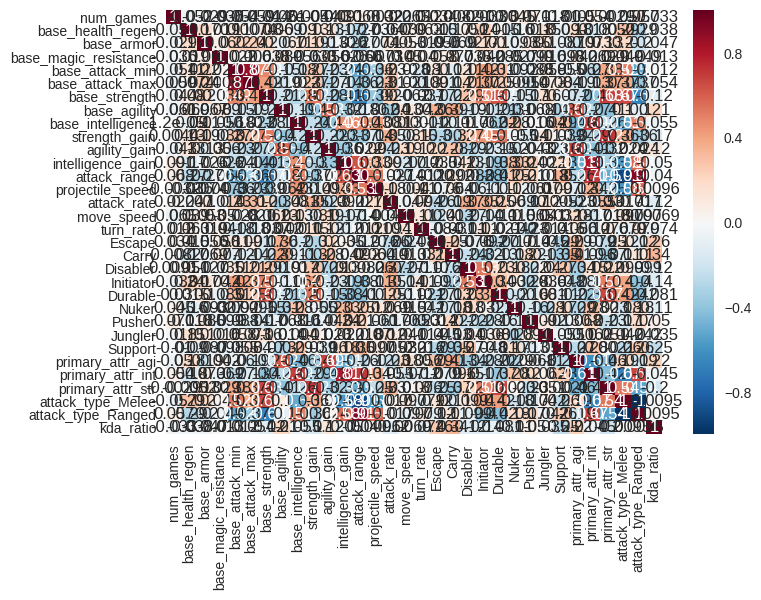

In [20]:
sns.heatmap(train_all[features + target].corr(),annot=True)

In [21]:
train_all[features + target].corr()

num_games  base_health_regen  base_armor  \
num_games               1.000000          -0.052145   -0.029293   
base_health_regen      -0.052145           1.000000    0.170125   
base_armor             -0.029293           0.170125    1.000000   
base_magic_resistance  -0.036044           0.018749    0.060061   
base_attack_min        -0.053909           0.113702    0.224424   
base_attack_max        -0.058538           0.007447    0.235543   
base_strength          -0.044127           0.079796    0.199002   
base_agility           -0.061363           0.069483   -0.067337   
base_intelligence      -0.000012          -0.090418    0.114601   
strength_gain           0.004413           0.128547    0.185320   
agility_gain           -0.042976           0.126858   -0.131001   
intelligence_gain       0.091455          -0.169986   -0.025537   
attack_range            0.067722          -0.268714   -0.272799   
projectile_speed       -0.003215          -0.035845   -0.073915   
attack_rate             0.021975          -0.046606    0.099983   
move_speed             -0.065459           0.039157    0.053099   
turn_rate               0.011647           0.062935   -0.019451   
Escape                  0.034062           0.014904   -0.055690   
Carry                  -0.008220          -0.169305   -0.069412   
Disabler                0.009051           0.050672   -0.027250   
Initiator              -0.033240           0.240281    0.167695   
Durable                -0.030218           0.015318    0.104770   
Nuker                   0.045429          -0.160771   -0.093303   
Pusher                  0.071409          -0.018204    0.084940   
Jungler                -0.018264           0.145728    0.104464   
Support                -0.010349          -0.090266   -0.086818   
primary_attr_agi       -0.050378           0.180167   -0.188139   
primary_attr_int        0.053895          -0.178996    0.073054   
primary_attr_str       -0.002867          -0.005225    0.133636   
attack_type_Melee      -0.056924           0.293338    0.200453   
attack_type_Ranged      0.056924          -0.293338   -0.200453   
kda_ratio              -0.033093          -0.038230   -0.046507   

                       base_magic_resistance  base_attack_min  \
num_games                          -0.036044        -0.053909   
base_health_regen                   0.018749         0.113702   
base_armor                          0.060061         0.224424   
base_magic_resistance               1.000000         0.022260   
base_attack_min                     0.022260         1.000000   
base_attack_max                     0.005997         0.874132   
base_strength                      -0.038487         0.486128   
base_agility                        0.089043        -0.150884   
base_intelligence                  -0.056141        -0.183522   
strength_gain                      -0.032790         0.267435   
agility_gain                        0.055796        -0.226279   
intelligence_gain                  -0.025950        -0.242440   
attack_range                       -0.066134        -0.528292   
projectile_speed                   -0.007314        -0.357152   
attack_rate                        -0.013789         0.227330   
move_speed                          0.049852        -0.028190   
turn_rate                           0.039586        -0.178694   
Escape                              0.057966         0.105593   
Carry                               0.076651        -0.124016   
Disabler                           -0.035329         0.114816   
Initiator                           0.042462         0.421764   
Durable                            -0.084662         0.312065   
Nuker                              -0.026585        -0.092176   
Pusher                             -0.098600        -0.088393   
Jungler                             0.015933         0.058227   
Support                            -0.097924        -0.055216   
primary_attr_agi                    0.042192        -0.0

# SelectKBest

In [386]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
ch2 = SelectKBest(chi2, k=4)
selector = SelectKBest(f_classif, k=5)
selector.fit_transform(train_all[features], train_all['kda_ratio'])


array([[  2.01000000e+02,   1.50000000e+01,   9.00000000e+02,
          1.00000000e+00,   0.00000000e+00],
       [  7.20000000e+01,   1.50000000e+01,   9.00000000e+02,
          1.00000000e+00,   0.00000000e+00],
       [  1.32000000e+02,   1.50000000e+01,   9.00000000e+02,
          1.00000000e+00,   0.00000000e+00],
       ..., 
       [  5.60000000e+01,   2.40000000e+01,   1.20000000e+03,
          0.00000000e+00,   1.00000000e+00],
       [  1.99000000e+02,   2.40000000e+01,   1.20000000e+03,
          0.00000000e+00,   1.00000000e+00],
       [  3.50000000e+01,   2.40000000e+01,   1.20000000e+03,
          0.00000000e+00,   1.00000000e+00]])

In [387]:
scores = selector.scores_
pd.DataFrame({'feature_name':features,'importance_scores':scores}).sort_values('importance_scores', ascending = False)


feature_name  importance_scores
0               num_games           4.586504
18                  Carry           1.193172
25                Support           1.118121
13       projectile_speed           1.113901
8       base_intelligence           1.104140
11      intelligence_gain           1.089373
16              turn_rate           1.080599
27       primary_attr_int           1.071518
5         base_attack_max           1.056190
17                 Escape           1.048135
26       primary_attr_agi           1.047274
10           agility_gain           1.022440
20              Initiator           1.017163
12           attack_range           1.015385
9           strength_gain           1.014255
30     attack_type_Ranged           0.995045
29      attack_type_Melee           0.995045
2              base_armor           0.990291
4         base_attack_min           0.986611
28       primary_attr_str           0.975534
7            base_agility           0.969437
15             move_speed           0.958458
23                 Pusher           0.958216
1       base_health_regen           0.948898
24                Jungler           0.932848
6           base_strength           0.928928
19               Disabler           0.924293
21                Durable           0.913305
22                  Nuker           0.894897
14            attack_rate           0.844597
3   base_magic_resistance           0.826286

In [388]:
selector.pvalues_

array([  6.83960565e-85,   8.05448504e-01,   5.69592467e-01,
         9.99181867e-01,   5.92811374e-01,   1.99844020e-01,
         8.86172231e-01,   6.97100260e-01,   6.28255132e-02,
         4.18894834e-01,   3.70009201e-01,   9.28435146e-02,
         4.12021757e-01,   4.77577146e-02,   9.97282548e-01,
         7.57838620e-01,   1.15441641e-01,   2.35043165e-01,
         3.33634567e-03,   9.01115868e-01,   4.01281402e-01,
         9.31011729e-01,   9.65454668e-01,   7.59111183e-01,
         8.72418626e-01,   4.22553044e-02,   2.39021332e-01,
         1.43002423e-01,   6.61099612e-01,   5.39426265e-01,
         5.39426265e-01])

In [379]:
'''
#chi2 for categorical features
selector = SelectKBest(chi2, k=5)
selector.fit_transform(train_all[[categorical_features]], train_all['kda_ratio'])
scores = selector.scores_

# Get the raw p-values for each feature, and transform from p-values into scores #Explore more
raw_p_values = -np.log10(selector.pvalues_)
'''

"\n#chi2 for categorical features\nselector = SelectKBest(chi2, k=5)\nselector.fit_transform(train_all[[categorical_features]], train_all['kda_ratio'])\nscores = selector.scores_\n\n# Get the raw p-values for each feature, and transform from p-values into scores\nscores = -np.log10(selector.pvalues_)\n"

# Recursive Feature Elimination

In [ ]:
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
from sklearn.feature_selection import RFE
#from sklearn.svm import SVC #for classsification
#svc = SVC(kernel="linear", C=1) #for classsification
#rfe = RFE(estimator=svc, n_features_to_select=5, step=1) #for classsification
from sklearn.svm import SVR
svr = SVR(kernel="linear")
rfe = RFE(estimator=svr, n_features_to_select=5, step=1)
rfe.fit(train_all[features], train_all['kda_ratio'])
ranking = rfe.ranking_.reshape(digits.images[0].shape)
rfe.ranking

In [ ]:
from sklearn.feature_selection import RFECV
#svc = SVC(kernel="linear") #For classification
#    The "accuracy" scoring is proportional to the number of correct classifications
#rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy') #For classification
from sklearn.svm import SVR
svr = SVR(kernel="linear")
rfecv = RFECV(estimator=svr, step=1, cv=StratifiedKFold(2), scoring='RMSE')
rfecv.fit(train_all[features], train_all['kda_ratio'])
print("Optimal number of features : %d" % rfecv.n_features_)
rfecv.ranking_
rfecv.grid_scores_

In [393]:
features
#

['num_games',
 'base_health_regen',
 'base_armor',
 'base_magic_resistance',
 'base_attack_min',
 'base_attack_max',
 'base_strength',
 'base_agility',
 'base_intelligence',
 'strength_gain',
 'agility_gain',
 'intelligence_gain',
 'attack_range',
 'projectile_speed',
 'attack_rate',
 'move_speed',
 'turn_rate',
 'Escape',
 'Carry',
 'Disabler',
 'Initiator',
 'Durable',
 'Nuker',
 'Pusher',
 'Jungler',
 'Support',
 'primary_attr_agi',
 'primary_attr_int',
 'primary_attr_str',
 'attack_type_Melee',
 'attack_type_Ranged']

In [59]:
dtrain = xgb.DMatrix(train_all[features], train_all['kda_ratio'], missing=np.nan)
dvalid = xgb.DMatrix(validation_all[features], missing=np.nan)
dtest = xgb.DMatrix(test_all[features], missing=np.nan)

watchlist = [(dtrain, 'train')]

In [60]:
nrounds = 850
params = {"objective": "reg:linear","booster": "gbtree", "nthread": 4,"silent": 1,"eta": 0.01, "max_depth": 8, "subsample": 0.01, "colsample_bytree": 0.3,"min_child_weight": 3,"seed": 2016,"tree_method": "exact"}
bst = xgb.train(params, dtrain, num_boost_round=nrounds, evals=watchlist, verbose_eval=400)
valid_preds = bst.predict(dvalid)
print(mean_squared_error(validation_set['kda_ratio'], valid_preds))


[0]	train-rmse:3668.65
[400]	train-rmse:898.087
[800]	train-rmse:881.246
635385.212052


In [64]:
test_preds = bst.predict(dtest)
sub = pd.DataFrame({'id':test_set['id'],'kda_ratio':test_preds})
i = i + 1
sub.to_csv('sub_' + str(i) + ".csv", index = False)


In [164]:
import lightgbm as lgb

In [165]:
dtrain = lgb.Dataset(train_all[features], train_all['kda_ratio'], free_raw_data=False)
dvalid = lgb.Dataset(validation_all[features], reference = dtrain, free_raw_data=False)

In [352]:
#http://lightgbm.readthedocs.io/en/latest/Parameters.html
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'rmse'},
    'num_leaves': 25,
    'learning_rate': 0.01,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.09,
    'tree_learner':'voting',
    'bagging_freq': 2,
    'max_depth':15,
    'min_data_in_leaf':22,
    'min_sum_hessian_in_leaf':1e-3,
    'feature_fraction':.6,
    'feature_fraction_seed':2,
    'bagging_fraction':.09,
    'bagging_freq':2,
    'bagging_seed':3,
    'early_stopping_round':0,
    #'lambda_l1':.4,
    #'lambda_l2':.1,
    'min_split_gain':0,
    'drop_rate':0.01,
    'skip_drop':0.5,
    'max_drop':1,
    'uniform_drop':'false',
    'xgboost_dart_mode':'false',
    'drop_seed':4,
    'top_rate':0.2,
    'other_rate':0.1,
    #'max_cat_threshold':32,
    #'cat_smooth':10,
    #'cat_l2':10,
    #'max_cat_to_onehot':4,
    'top_k':20,
    #'max_bin':50,
    #min_data_in_bin
    #data_random_seed
    #output_model
    #input_model
    #output_result
    #pre_partition
    #is_sparse
    #two_round
    #save_binary
    #verbosity
    #header
    #label
    #weight
    #query
    #ignore_column
    #categorical_feature
    #predict_raw_score
    #predict_leaf_index
    #predict_contrib
    #bin_construct_sample_cnt
    #num_iteration_predict
    #pred_early_stop
    #pred_early_stop_freq
    #pred_early_stop_margin
    #use_missing
    #zero_as_missing
    #init_score_file
    #valid_init_score_file
    #sigmoid
    #alpha
    #fair_c
    #poisson_max_delta_step
    #scale_pos_weight
    #boost_from_average
    #is_unbalance
    #max_position
    #label_gain
    #num_class
    #reg_sqrt
    #tweedie_variance_power

    'verbose': 0
}
evals_result = {}

In [353]:
print('Start training...')
# train
lgbm = lgb.train(params, dtrain, num_boost_round=950, valid_sets=dvalid,  evals_result=evals_result, verbose_eval=400)#early_stopping_rounds=500,

print('Save model...')
# save model to file
#lgbm.save_model('model.txt')

print('Start predicting...')
# predict
valid_preds = lgbm.predict(validation_all[features], num_iteration=lgbm.best_iteration)#num_iteration = num_trees
# eval
print('The rmse of prediction using validation set is:', mean_squared_error(validation_set['kda_ratio'], valid_preds) ** 0.5)
print('The mse of prediction using validation set is:', mean_squared_error(validation_set['kda_ratio'], valid_preds))

Start training...
[400]	valid_0's rmse: 3570.34	valid_0's l2: 1.27473e+07
[800]	valid_0's rmse: 3568.62	valid_0's l2: 1.27351e+07
Save model...
Start predicting...
The rmse of prediction using validation set is: 792.528756465
The mse of prediction using validation set is: 628101.829824


In [16]:
print('Feature names:', lgbm.feature_name())
print('Feature importances:', list(lgbm.feature_importance()))

Feature names: ['num_games', 'base_health_regen', 'base_armor', 'base_magic_resistance', 'base_attack_min', 'base_attack_max', 'base_strength', 'base_agility', 'base_intelligence', 'strength_gain', 'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed', 'attack_rate', 'move_speed', 'turn_rate', 'Escape', 'Carry', 'Disabler', 'Initiator', 'Durable', 'Nuker', 'Pusher', 'Jungler', 'Support', 'primary_attr_agi', 'primary_attr_int', 'primary_attr_str', 'attack_type_Melee', 'attack_type_Ranged']
Feature importances: [7182, 352, 1170, 34, 1434, 1117, 1097, 1284, 1067, 1171, 1231, 1146, 629, 666, 243, 947, 592, 390, 378, 203, 250, 203, 263, 183, 185, 227, 91, 103, 137, 23, 2]


In [214]:
test_preds = lgbm.predict(test_all[features])
sub = pd.DataFrame({'id':test_set['id'],'kda_ratio':test_preds})
i = i + 1
print(i)
sub.to_csv('lgbm_sub_' + str(i) + ".csv", index = False)

17


Plot metrics during training...


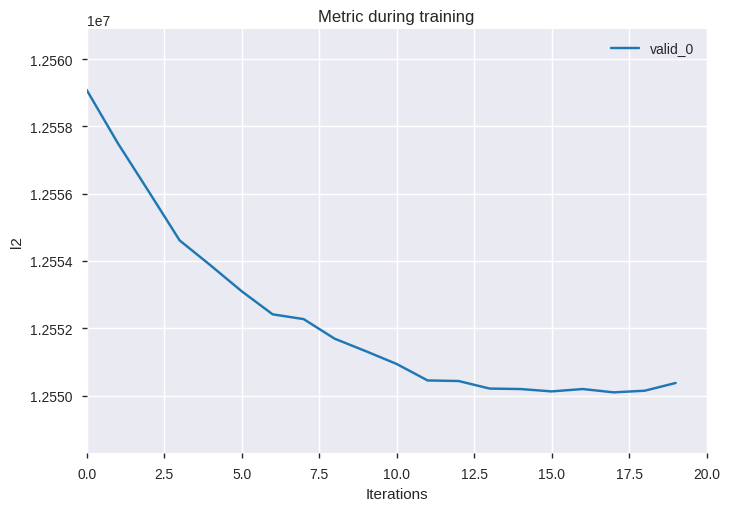

In [37]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='l2')

Plot feature importances...


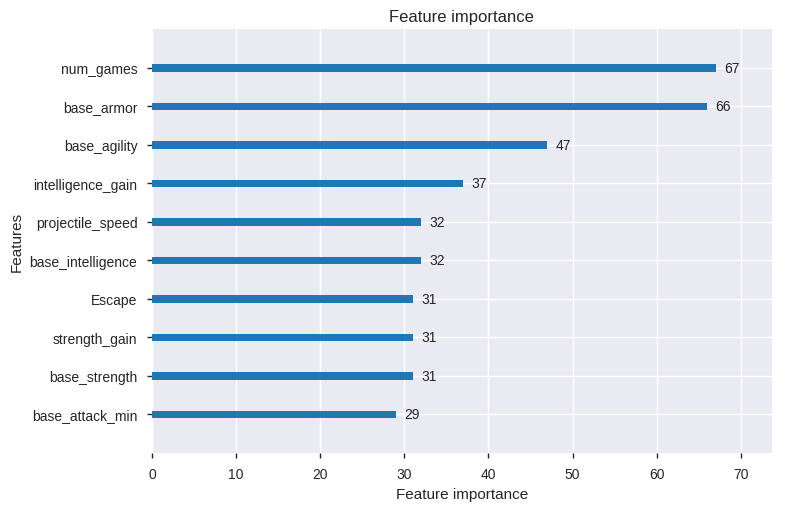

In [74]:
print('Plot feature importances...')
ax = lgb.plot_importance(lgbm, max_num_features=10)

Plot 4th tree...


ValueError: Invalid decision type in tree model.

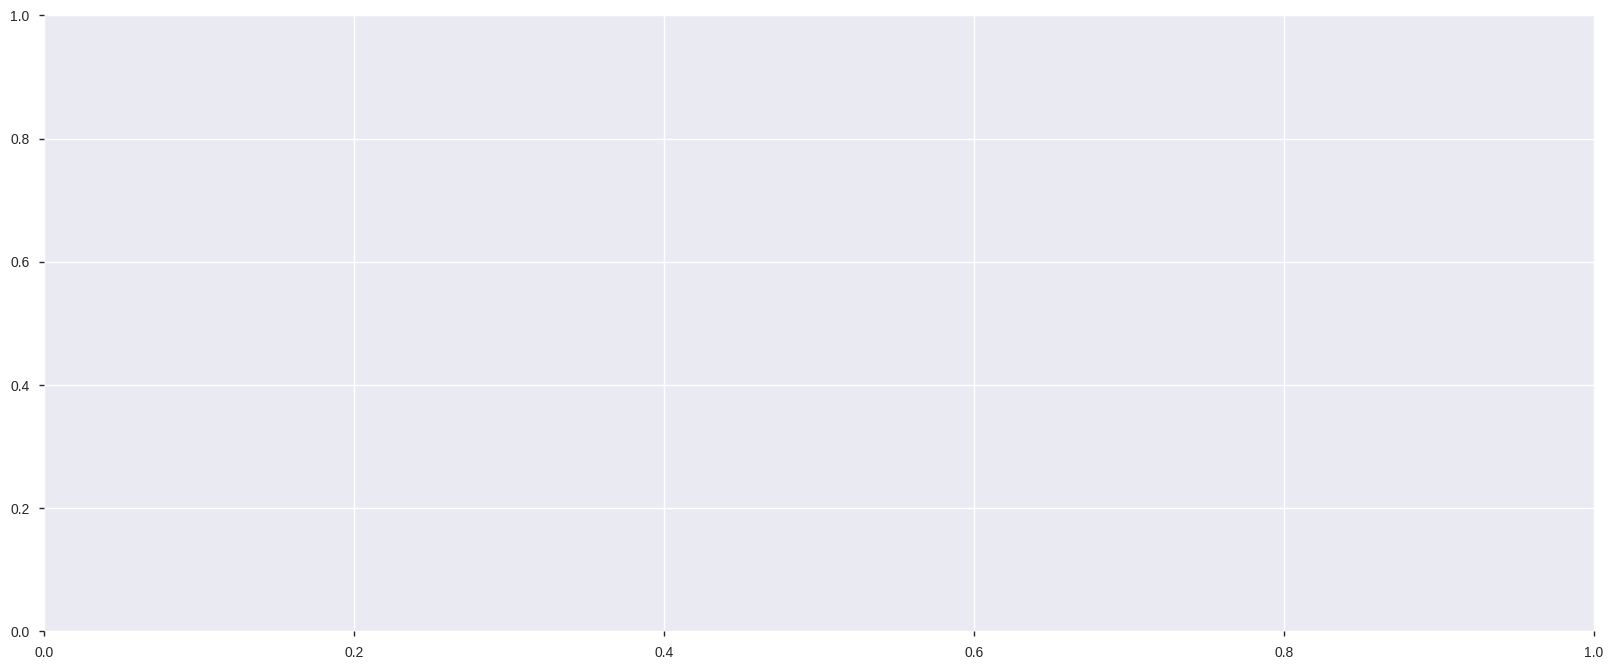

In [73]:
print('Plot 4th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(lgbm, tree_index=3, figsize=(20, 8), show_info=['split_gain'])

In [70]:
import graphviz
print('Plot 4th tree with graphviz...')
graph = lgb.create_tree_digraph(lgbm, tree_index=, name='Tree4')
graph.render(view=True)

Plot 4th tree with graphviz...


ValueError: Invalid decision type in tree model.

In [60]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}
estimator = lgb.LGBMRegressor(num_boost_round=20, early_stopping_rounds=5)
grid_lgbm = GridSearchCV(estimator, param_grid)
grid_lgbm.fit(train_all[features], train_all['kda_ratio'])
print('Best parameters found by grid search are:', grid_lgbm.best_params_)

Best parameters found by grid search are: {'n_estimators': 20, 'learning_rate': 1}


In [59]:
train_all[features].head()

num_games  base_health_regen  base_armor  base_magic_resistance  \
0        201                2.0         0.0                     25   
1         72                2.0         0.0                     25   
2        132                2.0         0.0                     25   
3        347                2.0         0.0                     25   
4         80                2.0         0.0                     25   

   base_attack_min  base_attack_max  base_strength  base_agility  \
0               33               39             23            23   
1               33               39             23            23   
2               33               39             23            23   
3               33               39             23            23   
4               33               39             23            23   

   base_intelligence  strength_gain         ...          Durable  Nuker  \
0                 15            2.1         ...                1      0   
1                 15            2.1         ...                1      0   
2                 15            2.1         ...                1      0   
3                 15            2.1         ...                1      0   
4                 15            2.1         ...                1      0   

   Pusher  Jungler  Support  primary_attr_agi  primary_attr_int  \
0       0        0        0                 1                 0   
1       0        0        0                 1                 0   
2       0        0        0                 1                 0   
3       0        0        0                 1                 0   
4       0        0        0                 1                 0   

   primary_attr_str  attack_type_Melee  attack_type_Ranged  
0                 0                  1                   0  
1                 0                  1                   0  
2                 0                  1                   0  
3                 0                  1                   0  
4                 0                  1                   0  

[5 rows x 31 columns]

In [61]:
'''
# dump model with pickle
with open('model.pkl', 'wb') as fout:
    pickle.dump(gbm, fout)
# load model with pickle to predict
with open('model.pkl', 'rb') as fin:
    pkl_bst = pickle.load(fin)
# can predict with any iteration when loaded in pickle way
y_pred = pkl_bst.predict(X_test, num_iteration=7)
# eval with loaded model
'''

"\n# dump model with pickle\nwith open('model.pkl', 'wb') as fout:\n    pickle.dump(gbm, fout)\n# load model with pickle to predict\nwith open('model.pkl', 'rb') as fin:\n    pkl_bst = pickle.load(fin)\n# can predict with any iteration when loaded in pickle way\ny_pred = pkl_bst.predict(X_test, num_iteration=7)\n# eval with loaded model\n"

In [75]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [78]:
#Try lgbm with sklearn wrapper
my_plots = plot_partial_dependence(sklearn_model,       
                                   features=[0,1,4], # column numbers of plots we want to show; index of columns we want to see
                                   X=train_all[features],            # raw predictors data.
                                   feature_names=['feature_1', 'feature_2', 'feature_3'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis


NameError: name 'bst' is not defined

In [57]:
from catboost import CatBoostRegressor
#https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostregressor-docpage/

In [163]:
#Description of each parameters: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_parameters-list-docpage/
model = CatBoostRegressor(depth=14, iterations=88, learning_rate=0.1,loss_function='RMSE', eval_metric='RMSE', random_seed=1,use_best_model=True,
                        l2_leaf_reg=6,
                        model_size_reg=None,#Didn't have any effect
                        rsm=0.5,#To enable random subspace method for feature bagging use 
                        border_count=20,#The number of splits for numerical features. Allowed values are integers from 1 to 255 inclusively.
                        feature_border_type=None,#string : The binarization mode (the possible values of objects are divided into disjoint ranges (buckets) delimited by the threshold values (splits)) for numerical features.Possible values:-> Median Uniform UniformAndQuantiles MaxLogSum MinEntropy GreedyLogSum 
                        fold_permutation_block_size=14,#int : Objects in the dataset are grouped in blocks before the random permutations. This parameter defines the size of the blocks. The smaller is the value, the slower is the training. Large values may result in quality degradation.
                        od_pval=None,#The threshold for the IncToDec overfitting detector type. The training is stopped when the specified value is reached. Requires that a test dataset was input.For best results, it is recommended to set a value in the range. The larger the value, the earlier overfitting is detected.
                        od_wait=1,
                        od_type=None,
                        nan_mode=None,
                        counter_calc_method="Universal",#'Universal', 'Static', 'Basic'
                        leaf_estimation_iterations=None,
                        leaf_estimation_method=None,
                        thread_count=None,
                        verbose=None,
                        logging_level=None,
                        metric_period=None,
                        ctr_leaf_count_limit=None,
                        store_all_simple_ctr=None,
                        max_ctr_complexity=None,
                        has_time=None,
                        one_hot_max_size=None,
                        random_strength=1,
                        name=None,
                        ignored_features=None,
                        train_dir=None,
                        custom_metric=None,
                        bagging_temperature=1.6,
                        save_snapshot=None,
                        snapshot_file=None,
                        fold_len_multiplier=2,
                        used_ram_limit=None,
                        gpu_ram_part=None,
                        allow_writing_files=None,
                        approx_on_full_history=None,
                        boosting_type="Dynamic",
                        simple_ctr=None,
                        combinations_ctr=None,
                        per_feature_ctr=None,
                        ctr_description=None,
                        task_type=None,
                        device_config=None,
                        devices=None)#, verbose=True
model.fit(train_all[features],train_all['kda_ratio'],cat_features=[],eval_set = (validation_all[features], validation_all['kda_ratio']),use_best_model = True)
valid_preds = model.predict(validation_all[features])
print('The rmse of prediction using validation set is:', mean_squared_error(validation_set['kda_ratio'], valid_preds) ** 0.5)
print('The mse of prediction using validation set is:', mean_squared_error(validation_set['kda_ratio'], valid_preds))

The rmse of prediction using validation set is: 790.435643515
The mse of prediction using validation set is: 624788.506538


In [156]:
test_preds = lgbm.predict(test_all[features])
sub = pd.DataFrame({'id':test_set['id'],'kda_ratio':test_preds})
i = i + 1
print(i)
sub.to_csv('catboost_sub_' + str(i) + ".csv", index = False)

12


# Ensemble Models

In [354]:
best_xgboost = pd.read_csv("sub_9.csv")
best_catboost = pd.read_csv("catboost_sub_12.csv")
best_lgbm = pd.read_csv("lgbm_sub_17.csv")

In [361]:
ans = (best_xgboost['kda_ratio'] + best_catboost['kda_ratio'] + best_lgbm['kda_ratio'])/3



array([ 2852.04493189,  2870.1353632 ,  2839.44051447,  2848.94964913,
        2848.94964913,  2912.98537637,  2911.3351413 ,  2839.82781172,
        2869.67994316,  2801.44551185,  3896.48734115,  3890.03286733,
        3910.39566   ,  3860.18621751,  4097.75962027,  3859.01666793,
        3983.5098164 ,  3852.74420901,  3912.14545588,  3984.83180497,
        3901.68618822,  3929.80398076,  4165.33650523,  3890.0120786 ,
        3930.92720149,  4088.91131815,  4017.50469103,  4032.1727294 ,
        3990.43881616,  4105.63636649,  3903.72139267,  3901.68618822,
        3903.69929256,  3900.87584498,  3907.39564436,  4143.66410491,
        3897.64628591,  3929.80398076,  4217.4154063 ,  4178.06516569,
        3901.68618822,  3866.80848076,  3900.25837637,  3899.56289508,
        3866.80848076,  3896.8709596 ,  3852.63508225,  3898.47075918,
        3876.71427354,  3173.93693935,  3176.68605626,  3283.86000531,
        3164.897603  ,  3223.22613837,  3190.22777463,  3216.2727741 ,
      

In [363]:
ensembled_sub = pd.DataFrame({'id':test_set['id'],'kda_ratio':ans.values})

In [364]:
ensembled_sub.head()

id    kda_ratio
0     3_53  2852.044932
1   287_53  2870.135363
2   884_53  2839.440514
3  1181_53  2848.949649
4  1578_53  2848.949649

In [365]:
ensembled_sub.to_csv("esembled_submission_1.csv",index=False)

# Stacking

In [366]:
#stack_train = 
#stack_test = pd.DataFrame({'best_xgboost_kda_ratio' : best_xgboost['kda_ratio'], 'best_catboost_kda_ratio' : best_catboost['kda_ratio'], 'best_lgbm_kda_ratio' : best_lgbm['kda_ratio']})


best_catboost_kda_ratio  best_lgbm_kda_ratio  best_xgboost_kda_ratio
0                2835.369052          2860.077023             2860.688721
1                2860.579865          2846.567192             2903.259033
2                2817.756071          2821.702680             2878.862793
3                2849.637558          2844.883509             2852.327881
4                2849.637558          2844.883509             2852.327881
5                2891.600770          2906.846082             2940.509277
6                2877.092216          2880.365112             2976.548096
7                2838.122244          2838.491562             2842.869629
8                2859.506109          2857.107939             2892.425781
9                2819.157211          2808.061893             2777.117432
10               3907.334990          3905.625324             3876.501709
11               3905.994652          3892.802192             3871.301758
12               3919.993740          3912.084598             3899.108643
13               3885.289269          3880.456640             3814.812744
14               4063.747034          4143.728604             4085.803223
15               3882.447938          3872.695084             3821.906982
16               3993.234815          4004.896441             3952.398193
17               3882.630347          3868.715806             3806.886475
18               3923.632043          3923.757693             3889.046631
19               3987.344358          3993.583675             3973.567383
20               3943.193240          3907.836272             3854.029053
21               3946.314470          3921.307434             3921.790039
22               4116.414613          4226.017754             4153.577148
23               3901.066529          3878.762431             3890.207275
24               3939.582949          3938.785081             3914.413574
25               4072.922030          4154.378575             4039.433350
26               4022.604347          4084.821103             3945.088623
27               4031.407585          4101.238289             3963.872314
28               3998.614748          4010.721231             3961.980469
29               4078.505958          4141.930485             4096.472656
..                       ...                  ...                     ...
868              2652.007044          2671.311549             2806.020020
869              3154.271424          3088.477333             3254.039795
870              3157.852224          3077.675240             3226.907959
871              3337.182611          3309.950510             3455.675781
872              3279.168020          3290.452784             3343.538574
873              3558.588913          3609.484349             3628.988525
874              3449.890209          3473.551598             3581.121094
875              3438.392762          3450.926683             3565.427002
876              3873.513772          3994.023563             3824.309814
877              3803.130126          3812.460139             3893.006836
878              3869.324013          3885.047057             3882.468262
879              3674.171981          3594.214543             3655.478760
880              3648.128468          3601.654148             3624.470459
881              3704.333534          3731.845971             3837.177979
882              2653.755869          2625.990566             2706.120605
883              3021.883546          3071.088725             3072.614502
884              2111.988497          2074.605337             2401.256348
885              3394.982549          3448.489118             3288.787354
886              3659.977744          3772.692794             3600.560791
887              3247.425636          3264.379581             3131.741943
888              3999.088162          4093.828489             4107.919922
889              3714.933385          3607.038904             3692.500488
890      